# A1: Classification Model Development

Machine Learning - DAT-5303 - BMBAN2<br>
Lars Marius Strømberg Jappée

In [1]:
# importing libraries
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import numpy as np
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
import gender_guesser.detector as gender # guess gender based on (given) name

# specifying file
file = "./GOT_character_predictions.xlsx"

# import excel file
got = pd.read_excel(io = file,
                    header = 0,
                    sheet_name = 0)


# User-Defined Functions

In [2]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.10,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed,
                                                        stratify     = y_data)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df


#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
 

# Missing Values

In [3]:
# running the mv_flagger function to get missing values and potentially use them as a boolean
got = mv_flagger(df = got)

# Feature Engineering

In [4]:
# Splitting popularity into three popular and unpopular, and neutral.

# creating different popularity columns
got['popular'] = 0
got['unpopular'] = 0
got['neutral'] = 0

# replacing values based on condition
for index, val in got.iterrows():

    if got.loc[index, 'popularity'] > 0.5:
        got.loc[index, 'popular'] = 1
        
    elif got.loc[index, 'popularity'] > 0:
        got.loc[index, 'neutral'] = 1
       
    elif got.loc[index, 'popularity'] == 0:
        got.loc[index, 'unpopular'] = 1

### Year Calculation and New Features

No known Character has lived beyond 100 years. Setting anyone born more than 100 years ago in a separate columns.


In [5]:
# calculating year and oldest recorded person
# std to remove any outliers in both directions, given a story will most
# likely have people living "now" in their timeline using mode to set year
yearstd = got.loc[ : , 'dateOfBirth'].std()
yearstd = got.loc[ : , 'dateOfBirth'] < yearstd
year = got[yearstd].loc[ : , 'dateOfBirth'] + got[yearstd].loc[ : , 'age']
year = year.mode()[0]

yearbefore = year - got['age'].max()
yearbefore = int(yearbefore)

# creating a born in a different era column based on birth year
got[f'birth_before_{yearbefore}'] = 0

# replacing values based on condition
for index, val in got.iterrows():
    if got.loc[index, 'dateOfBirth'] < yearbefore:
        got.loc[index, f'birth_before_{yearbefore}'] = 1

In [6]:
# creating different column based on if age + year of birth is lower than current year
got['age_birth_year'] = 0

# replacing values based on condition
for index, val in got.iterrows():
    if got.loc[index, 'dateOfBirth'] + got.loc[index, 'age'] < year:
        got.loc[index, 'age_birth_year'] = 1

In [7]:
# creating different column based on birth year is equal or greater than current
# to see if still alive based on age
got['age_equal_year'] = 0

# replacing values based on condition
for index, val in got.iterrows():
    if got.loc[index, 'dateOfBirth'] + got.loc[index, 'age'] >= year:
        got.loc[index, 'age_equal_year'] = 1

In [8]:
# splitting name and creating count of nr of names using user defined function
text_split_feature('name', got, sep=' ', new_col_name='nr_names')

In [9]:
# Creating count of how many times in book
got['nr_books'] = got['book1_A_Game_Of_Thrones'] +\
got['book2_A_Clash_Of_Kings'] +\
got['book3_A_Storm_Of_Swords'] +\
got['book4_A_Feast_For_Crows'] +\
got['book5_A_Dance_with_Dragons']

got['referenced'] = 0

# looping to to create boolean of if the person is in book or referenced
for index, val in got.iterrows():
     
    if got.loc[ index , 'nr_books'] == 0:
        got.loc[index, 'referenced'] = 1


In [10]:
# two in a row then not in book
got['two_then_not'] = 0

for index, val in got.iterrows():
    
    # setting two then not in next book
    if got.loc[ index , 'book1_A_Game_Of_Thrones'] == 1\
    and got.loc[ index , 'book2_A_Clash_Of_Kings'] == 1\
    and got.loc[ index , 'book3_A_Storm_Of_Swords'] == 0:
        got.loc[index, 'two_then_not'] = 1
        
    if got.loc[ index , 'book2_A_Clash_Of_Kings'] == 1\
    and got.loc[ index , 'book3_A_Storm_Of_Swords'] == 1\
    and got.loc[ index , 'book4_A_Feast_For_Crows'] == 0:
        got.loc[index, 'two_then_not'] = 1
        
    if got.loc[ index , 'book3_A_Storm_Of_Swords'] == 1\
    and got.loc[ index , 'book4_A_Feast_For_Crows'] == 1\
    and got.loc[ index , 'book5_A_Dance_with_Dragons'] == 0:
        got.loc[index, 'two_then_not'] = 1
        


In [11]:
# creating a boolean of only in book five
got['only_book5'] = 0

for index, val in got.iterrows():
    
    # checking for Miss.
    if got.loc[ index , 'book5_A_Dance_with_Dragons'] == 1\
    and got.loc[ index , 'nr_books'] == 1:
        got.loc[index, 'only_book5'] = 1

In [12]:
# creating boolean for people only in last book
got['not_in_last'] = 0

for index, val in got.iterrows():
    
    # checking for Miss.
    if got.loc[ index , 'nr_books'] >= 3\
    and got.loc[ index , 'book5_A_Dance_with_Dragons'] == 0:
        got.loc[index, 'not_in_last'] = 1

## Gender Guesser

Gender guesser could not be used within time limit, an option would have been <br>
to only use it on a few given an if statement. Or to export to excel and include <br>
with submission.

In [13]:
# # placeholder list
# placeholder_lst = []

# # looping over each name
# for index, col in got.iterrows():
    
#     # splitting each name
#     name_split = got.loc[index, 'name'].split()
    
#     # appending placeholder_lst with the results
#     placeholder_lst.append(name_split)
    

# # converting placeholder_lst into a DataFrame 
# name_split = pd.DataFrame(placeholder_lst)

# # renaming column to concatenate
# name_split.columns = ['first_name', 'name2', 'name3', 'name4', 'name5', 'name6']

# # concatenating first name with got
# got = pd.concat([got, name_split['first_name']],
#                    axis = 1)

In [14]:
# # guessing gender based on (given) name

# # placeholder list
# placeholder_lst = []

# # looping to guess gender
# for name in got['first_name']:
#     guess = gender.Detector().get_gender(name)
#     print(guess)
#     placeholder_lst.append(guess)

# # converting list into a series
# got['gender_guess'] = pd.Series(placeholder_lst)


### Dummies one hot adding

In [15]:
# # one hot encoding variables
# one_hot_gender_guess       = pd.get_dummies(got['gender_guess'])

# # joining codings together
# got = got.join(other = [one_hot_gender_guess])

# # dropping categorical variables after they've been encoded
# got = got.drop(['female', 'male', 'mostly_female', 'mostly_male', 'andy',
#                 'gender_guess', 'first_name'], axis = 1)

# logistic regression

Testing area for features.

In [16]:
# # declaring explanatory variables
# got_data = got.drop(['isAlive'],
#                              axis = 1)

# # declaring response variable
# got_target = got.loc[ : ,'isAlive']

# # train-test split with stratification
# x_train, x_test, y_train, y_test = train_test_split(
#             got_data,
#             got_target,
#             test_size    = 0.10,
#             random_state = 219,
#             stratify     = got_target) # preserving balance

# # merging training data for statsmodels
# got_train = pd.concat([x_train, y_train], axis = 1)

In [17]:
# # creating a (Pearson) correlation matrix
# df_corr = got.corr().round(2)

# # printing (Pearson) correlations with isAlive
# print(df_corr.loc['isAlive'].sort_values(ascending = False))

In [18]:
# for val in got:
#     print(f"{val} + ")

In [19]:
# # instantiating a logistic regression model object
# logistic_full = smf.logit(formula = """ isAlive ~ 
# nr_books + 
# popularity + 
# age_birth_year
# """,
# data    = got)


# # fitting the model object
# results_full = logistic_full.fit(maxiter = 1000)


# # checking the results SUMMARY
# results_full.summary2()

# Final Data

In [20]:
variables = [
'not_in_last',
'book1_A_Game_Of_Thrones',
'book2_A_Clash_Of_Kings',
'book4_A_Feast_For_Crows',
'age_birth_year',
'age_equal_year',
'popularity',
'only_book5',
'two_then_not'
]


In [21]:
# train/test split with the full model
got_data   =  got.loc[: , variables]
got_target =  got.loc[ : , 'isAlive']

# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target)

## Hyperparameter Tuning Notes

The tuning array were chosen based on the largest impact i could see with the <br>
least fine tuning. Mostly using the different named options, with some <br>
exceptions. The required criterion was included.

# Logistic Regression

## Hyperparameter Tuning

In [22]:
# # declaring a hyperparameter space
# class_weight = ['balanced', 'dict', 'None'] # Keeping to the simplest fewest variables to effectivize.
# solver_range = ['newton-cg', 'sag', 'lbfgs', 'saga'] # Keeping to the simplest fewest variables to effectivize.


# # creating a hyperparameter grid
# param_grid = {'class_weight' : class_weight,
#               'solver'     : solver_range}


# # INSTANTIATING the model object without hyperparameters
# lr_tuned = LogisticRegression(random_state = 219,
#                               max_iter     = 100) # increased for convergence


# # GridSearchCV object
# lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 12,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)


# # FITTING to the FULL DATASET (due to cross-validation)
# lr_tuned_cv.fit(got_data, got_target)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", lr_tuned_cv.best_params_)
# print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

## Logistic Regression

In [23]:

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'newton-cg',
                            class_weight = 'balanced',
                            random_state = 219)


# FITTING to the train dataset(could use full, due to tuning)
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


Training ACCURACY: 0.7236
Testing  ACCURACY: 0.7846
AUC Score        : 0.8159

True Negatives : 44
False Positives: 6
False Negatives: 36
True Positives : 109



## Coefficients

In [24]:
# zipping each feature name to its coefficient
logreg_model_values = zip(got_data.columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))

# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]

# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    
# checking the results
for pair in logreg_model_lst:
    print(pair)


('intercept', -0.0)
('not_in_last', -0.46)
('book1_A_Game_Of_Thrones', -0.48)
('book2_A_Clash_Of_Kings', -0.4)
('book4_A_Feast_For_Crows', 1.34)
('age_birth_year', -4.15)
('age_equal_year', 3.94)
('popularity', -2.62)
('only_book5', 0.65)
('two_then_not', -0.22)


# Classification Trees (CART Models)

## Hyperparameter Tuning

In [25]:
# # declaring a hyperparameter space
# criterion = ['gini', 'entropy']
# splitter  = ['best', 'random']
# max_depth = np.arange(2, 8)


# # creating a hyperparameter grid
# param_grid = {'criterion' : criterion,
#               'splitter'  : splitter,
#               'max_depth' : max_depth,}


# # INSTANTIATING the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# # RandomizedSearchCV object
# tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 24,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_tree_cv.fit(got_data, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_tree_cv.best_params_)
# print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

## Classification Trees (CART Models)

In [26]:
# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth = 7,
                                     min_samples_leaf = 30, # to keep enough samples in each
                                     random_state = 219,
                                     splitter = 'best',
                                     criterion = 'entropy')


# FITTING to the train dataset(could use full, due to tuning)
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
tree_pruned_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pruned_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pruned_pred).round(4)


# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pruned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")



Training ACCURACY: 0.8521
Testing  ACCURACY: 0.9128
AUC Score        : 0.8366

True Negatives : 34
False Positives: 16
False Negatives: 1
True Positives : 144



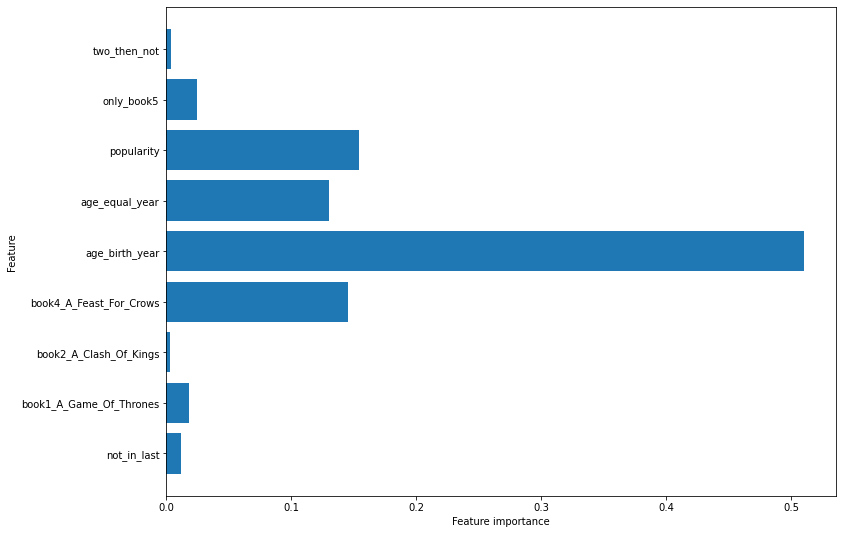

In [27]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = x_train,
                         export = False)

# KNN

## Standard Scaler

In [28]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(got_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(got_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            got_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = got_target)

## Hyperparameter Tuning 

In [29]:
# # determining the optimal number of neighbors
# opt_neighbors = optimal_neighbors(x_data        = x_scaled_df,
#                                   y_data        = got_target,
#                                   response_type = 'class')


In [30]:
# # declaring a hyperparameter space
# n_neighbors = [opt_neighbors]
# weights  = ['uniform', 'distance']
# algorithm      = ['auto', 'ball_tree', 'ball_tree', 'kd_tree', 'brute']
# leaf_size       = np.arange(10, 100)
# metric    = ['minkowski', 'euclidean', 'manhattan']

# # creating a hyperparameter grid
# param_grid = {'n_neighbors' : n_neighbors,
#               'weights'         : weights,
#               'algorithm'        : algorithm,
#               'leaf_size' : leaf_size,
#               'metric'     : metric}


# # INSTANTIATING the model object without hyperparameters
# tuned_knn = KNeighborsClassifier(n_neighbors = opt_neighbors)


# # RandomizedSearchCV object
# tuned_knn_cv = RandomizedSearchCV(estimator             = tuned_knn,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_knn_cv.fit(got_data, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_knn_cv.best_params_)
# print("Tuned Training AUC:", tuned_knn_cv.best_score_.round(4))

## KNN

In [31]:

# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = 14,
                               weights = 'distance',
                               metric = 'euclidean',
                               leaf_size = 76,
                               algorithm = 'brute')

# FITTING to the train dataset(could use full, due to tuning)
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)

# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)

# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_scaled,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test_scaled,
                                          y_score = knn_pred).round(4)

# unpacking the confusion matrix
knn_tn, \
knn_fp, \
knn_fn, \
knn_tp = confusion_matrix(y_true = y_test_scaled, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tn}
False Positives: {knn_fp}
False Negatives: {knn_fn}
True Positives : {knn_tp}
""")



Training ACCURACY: 0.8995
Testing  ACCURACY: 0.8615
AUC Score        : 0.8414

True Negatives : 40
False Positives: 10
False Negatives: 17
True Positives : 128



# Random Forest

## Hyper Tuning 

In [32]:
# # INSTANTIATING a random forest model with default values
# rf_default = RandomForestClassifier(n_estimators     = 100,
#                                     criterion        = 'gini',
#                                     max_depth        = 4,
#                                     min_samples_leaf = 1,
#                                     bootstrap        = True,
#                                     warm_start       = False,
#                                     random_state     = 219)

# # FITTING the training data
# rf_default_fit = rf_default.fit(x_train, y_train)


# # PREDICTING based on the testing set
# rf_default_fit_pred = rf_default_fit.predict(x_test)


# # declaring a hyperparameter space
# criterion = ['gini', 'entropy']
# max_depth = np.arange(2, 8)
# n_estimators = np.arange(10, 500, 10)

# # creating a hyperparameter grid
# param_grid = {'criterion'     : criterion,
#               'max_depth'        : max_depth,
#               'n_estimators' : n_estimators}

# # INSTANTIATING the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)

# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 558,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# forest_cv.fit(got_data, got_target)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(4))

## Random Forrest

Forest Tuned Training ACCURACY: 0.8652
Forest Tuned Testing  ACCURACY: 0.9026
Forest Tuned AUC Score        : 0.8362

True Negatives : 35
False Positives: 15
False Negatives: 4
True Positives : 141



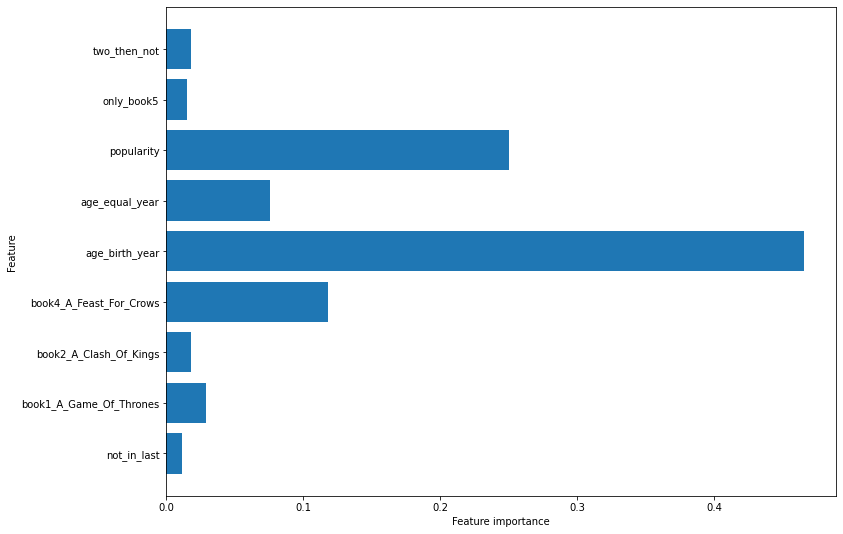

In [33]:
# building a model based on hyperparameter tuning results

# INSTANTIATING with best_estimator
forest_tuned = RandomForestClassifier(criterion='gini', 
                                      n_estimators=70, 
                                      random_state=219, 
                                      max_depth = 7)


# FITTING to the train dataset(could use full, due to tuning)
forest_tuned_fit = forest_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

# Gradient Boosted Machines

## Hyper Tuning

In [34]:
# # declaring a hyperparameter space
# learning_rate        = np.arange(0.1, 2.2, 0.5)
# n_estimators    = np.arange(1, 200, 25)
# max_depth        = np.arange(2, 8, 1)
# min_samples_leaf   = np.arange(30, 51, 5)

# # creating a hyperparameter grid
# param_grid = {'learning_rate' : learning_rate,
#               'n_estimators'     : n_estimators,
#               'max_depth'  : max_depth,
#               'min_samples_leaf'    : min_samples_leaf}


# # INSTANTIATING the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# # GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 219,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# full_gbm_cv.fit(x_train, y_train)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

## Gradient Boosted Machines

In [35]:
# INSTANTIATING with best_estimator
gbm_tuned = GradientBoostingClassifier(n_estimators = 1,
                                       min_samples_leaf     = 30,
                                       max_depth  = 5,
                                       learning_rate  = 1.1)


# FITTING to the train dataset(could use full, due to tuning)
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

# declaring model performance objects
gbm_train_acc = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_test_acc  = gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = gbm_tuned_pred).round(4)



Training ACCURACY: 0.8212
Testing  ACCURACY: 0.8923
AUC Score        : 0.8686

True Negatives : 41
False Positives: 9
False Negatives: 12
True Positives : 133



# Final Output

In [36]:
# comparing results and choosing final, based on high AUC and all scores lower 
# than 0.9
print(f"""
Model         AUC Score      Training Accuracy      Testing Accuracy\
    TN, FP, FN, TP
-----         ---------      -----------------      ----------------\
    --------------
Logistic      {logreg_auc_score}         {logreg_train_score}\
                 {logreg_test_score}\
              {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Tree          {pruned_tree_auc_score}         {pruned_tree_train_score}\
                 {pruned_tree_test_score}\
              {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
KNN           {knn_auc_score}         {knn_train_score}\
                 {knn_test_score}\
              {knn_tn, knn_fp, knn_fn, knn_tp}
Random Forest {forest_tuned_auc}         {forest_tuned_train_score}\
                 {forest_tuned_test_score}\
              {tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp}
*GBM          {gbm_auc}         {gbm_train_acc}\
                 {gbm_test_acc}\
              {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}

*Final Model""")



Model         AUC Score      Training Accuracy      Testing Accuracy    TN, FP, FN, TP
-----         ---------      -----------------      ----------------    --------------
Logistic      0.8159         0.7236                 0.7846              (44, 6, 36, 109)
Tree          0.8366         0.8521                 0.9128              (34, 16, 1, 144)
KNN           0.8414         0.8995                 0.8615              (40, 10, 17, 128)
Random Forest 0.8362         0.8652                 0.9026              (35, 15, 4, 141)
*GBM          0.8686         0.8212                 0.8923              (41, 9, 12, 133)

*Final Model
